# Toronto Brewery Location Selection for Brew Master Stakeholders

### Introduction

Stakeholders for a team of Master Brewers are interested in opening a new Brewery. According to the Brewers Association, between 2014-2018 the number of breweries has grown at a rate of 12.9%. Though masters of their craft, the Stakeholders are unsure as to where to place the location of the Brewery, however they have decided the city of choice to be Toronto, CA.

### Business Problem

The Stakeholders would like to identify a primary area for a new brewery in the city of Toronto. Additionally, the location should not be too close in proximity to another brewery as this may create unwanted competition.

### Data

Based on the probelm the Stakeholders have presented, the following data will be used for the analysis:

Foursquare location data to identify how many breweries are in a given area.

Wikipedia to retrieve postal code data for Toronto.

Geospatial data for Toronto that will provide appropriate longitude and latitude coordinates to create necessary dataframes.

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup # library to parse HTML and XML documents

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
done

# All requested packages already installed.

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
done

# All requested packages already installed.

Libraries imported.


## Methodology

Collect the data, extract the data for Toronto.

Next, clean and merge the data with Geospatial data in order to create a complete DataFrame.

Once the DataFrame is created, A Folium Map will be generated. Then using Foursquare location data, K-Means Clustering will be used to identify specific clusters of Boroughs that will be desirable locations for a new Brewery.

### Scrape Toronto Postal Codes from Wikipedia, then transform into dataframe using BeautifulSoup

In [2]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))

In [3]:
neighborhood=pd.DataFrame(df[0])

### Clean data and ignore cells with a borough that is Not assigned

In [4]:
# Ignore cells with a borough that is Not assigned
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhoods'] = (((((row.span.text).split('(')[1]).strip('(')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boces25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Cenre969 Eastern':'East Toronto Business',
                                     'MississaugaCanada Post Gateway processing Centre':'Mississauga'})

        


In [5]:
df.head()

,PostalCode,Borough,Neighborhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [6]:
df.shape

(103, 3)

### Use Geospatial Dataset to merge Latitude and Longitude with previous Dataframe

In [7]:
# Use GeoSpatial Dataset from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
geosp_df=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')

In [8]:
geosp_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Merge Lat Lng with previous dataframe
geosp_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [10]:
geosp_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
toronto_df = pd.merge(df, geosp_df, on='PostalCode', how='left')
toronto_df.head(103)

,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [12]:
toronto_df.shape

(103, 5)

### Get Latitude and Longitude of Toronto

In [13]:
address = 'Toronto'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


### Create map of Toronto using latitude and longitude values

In [14]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### filter borough names that contain the word Toronto

In [15]:
borough_names = list(toronto_df.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['Downtown Toronto',
 'East Toronto',
 'West Toronto',
 'East YorkEast Toronto',
 'Central Toronto',
 'Downtown TorontoStn A PO Boxes25 The Esplanade',
 'East TorontoBusiness reply mail Processing Centre969 Eastern']

### create a new DataFrame with only boroughs that contain the word Toronto

In [16]:
toronto_df = toronto_df[toronto_df['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(toronto_df.shape)
toronto_df.head()

(39, 5)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### Use Foursquare API to explore the Neighborhoods

In [18]:
CLIENT_ID = 'FE33F4R14QJ1IRDTONCJOSZPYNC05DVQGWT2ZB0JDMIDRJ4D' # your Foursquare ID
CLIENT_SECRET = '4KOHFDNKHUDNZSGWHMYNAB1D0QFVLFALPQNQBP450CMWPRON' # your Foursquare Secret
VERSION = '20210428' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FE33F4R14QJ1IRDTONCJOSZPYNC05DVQGWT2ZB0JDMIDRJ4D
CLIENT_SECRET:4KOHFDNKHUDNZSGWHMYNAB1D0QFVLFALPQNQBP450CMWPRON


### Get the top 100 venues within a 500 meter radius.

In [19]:
radius = 1000
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['PostalCode'], toronto_df['Borough'], toronto_df['Neighborhoods']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [20]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhoods', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(3194, 9)


,PostalCode,Borough,Neighborhoods,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Distillery Sunday Market,43.650075,-79.361832,Farmers Market


### Check how many venues returned for each Postal Code

In [21]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhoods"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhoods,,,,,,
M4E,East Toronto,The Beaches,83,83,83,83,83,83
M4J,East YorkEast Toronto,The Danforth East,92,92,92,92,92,92
M4K,East Toronto,"The Danforth West, Riverdale",100,100,100,100,100,100
M4L,East Toronto,"India Bazaar, The Beaches West",78,78,78,78,78,78
M4M,East Toronto,Studio District,100,100,100,100,100,100
M4N,Central Toronto,Lawrence Park,10,10,10,10,10,10
M4P,Central Toronto,Davisville North,100,100,100,100,100,100
M4R,Central Toronto,North Toronto West,48,48,48,48,48,48
M4S,Central Toronto,Davisville,100,100,100,100,100,100


### Find count of how many unique categories

In [22]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 279 uniques categories.


In [23]:
venues_df['VenueCategory'].unique()[:50]

array(['Bakery', 'Coffee Shop', 'Historic Site', 'Distribution Center',
       'Farmers Market', 'Park', 'Restaurant', 'Chocolate Shop',
       'Mediterranean Restaurant', 'Performing Arts Venue', 'Spa',
       'Breakfast Spot', 'Italian Restaurant', 'Liquor Store',
       'Dessert Shop', 'French Restaurant', 'Thai Restaurant', 'Café',
       'Pub', 'Gym / Fitness Center', 'Tech Startup', 'Yoga Studio',
       'Pool', 'Theater', 'Shoe Store', 'Animal Shelter', 'Gastropub',
       'Event Space', 'Furniture / Home Store', 'Diner',
       'German Restaurant', 'Art Gallery', 'Pizza Place', 'Grocery Store',
       'Brewery', 'Sandwich Place', 'Cosmetics Shop', 'Food Truck',
       'Middle Eastern Restaurant', 'Gym Pool', 'Bar',
       'Athletics & Sports', 'Sushi Restaurant', 'Dance Studio',
       'Karaoke Bar', 'Electronics Store', 'Indian Restaurant',
       'Pet Store', 'Bank', 'Auto Dealership'], dtype=object)

### Analyze each area

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhoods'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(3194, 282)


,PostalCode,Borough,Neighborhoods,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Zoo
0,M5A,Downtown Toronto,"Re

### Group rows by Neighborhood and by taking the mean of the frequency of each category

In [25]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(39, 282)


,PostalCode,Borough,Neighborhoods,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Zoo
0,M4E,East Toronto,The Bea

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create new dataframe and list top 5 venues by Postal  Code

In [27]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Pub,Coffee Shop,Pizza Place,Japanese Restaurant,Beach,Breakfast Spot,Park,Asian Restaurant,Bar,Nail Salon
1,M4J,East YorkEast Toronto,The Danforth East,Café,Greek Restaurant,Coffee Shop,Convenience Store,Beer Bar,Ethiopian Restaurant,Fast Food Restaurant,Pizza Place,American Restaurant,Pharmacy
2,M4K,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Café,Pub,Fast Food Restaurant,Italian Restaurant,Bank,Discount Store,Bakery,Yoga Studio
3,M4L,East Toronto,"India Bazaar, The Beaches West",Indian Restaurant,Coffee Shop,Café,Grocery Store,Fast Food Restaurant,Restaurant,Beach,Gym,Sandwich Place,Bakery
4,M4M,East Toronto,Studio District,Coffee Shop,American Restaurant,Vietnamese Restaurant,Bar,Diner,Café,Brewery,Bakery,French Restaurant,Italian Restaurant
5,M4N,Central Toronto,Lawrence Park,College Gym,Bookstore,Pharmacy,Gym / Fitness Center,Trail,Coffee Shop,College Quad,Park,Café,Bus Line
6,M4P,Central Toronto,Davisville North,Coffee Shop,Restaurant,Italian Restaurant,Café,Sushi Restaurant,Pizza Place,Sandwich Place,Dessert Shop,Gym,Movie Theater
7,M4R,Central Toronto,North Toronto West,Italian Restaurant,Park,Coffee Shop,Thai Restaurant,Sporting Goods Shop,Diner,Restaurant,Café,Mexican Restaurant,Skating Rink
8,M4S,Central Toronto,Davisville,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Restaurant,Café,Indian Restaurant,Sandwich Place,Middle Eastern Restaurant,Gym
9,M4T,Central Toronto,"Moore Park, Summerhill East",Coffee Shop,Grocery Store,Italian Restaurant,Park,Gym,Thai Restaurant,Café,Bank,Sushi Restaurant,Playground


#### Extract Brewery Data

In [28]:
toronto_Brewery = toronto_grouped[["Borough","Brewery"]]
toronto_Brewery

,Borough,Brewery
0,East Toronto,0.000000
1,East YorkEast Toronto,0.000000
2,East Toronto,0.010000
3,East Toronto,0.025641
4,East Toronto,0.040000
5,Central Toronto,0.000000
6,Central Toronto,0.010000
7,Central Toronto,0.000000
8,Central Toronto,0.010000
9,Central Toronto,0.000000


In [29]:
toronto_Brewery.max()

Borough    West Toronto
Brewery        0.061224
dtype: object

In [30]:
# Now let's merge the Toronto Geodat and the Toronto Brewery data per Neighborhood
toronto_Brewery_merged = pd.merge(toronto_df, toronto_Brewery, on='Borough')

# Now, let's change the columns order
toronto_Brewery_merged = toronto_Brewery_merged.reindex(columns=['PostalCode','Borough','Brewery','Latitude','Longitude'])

toronto_Brewery_merged

,PostalCode,Borough,Brewery,Latitude,Longitude
0,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
1,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
2,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
3,M5A,Downtown Toronto,0.020000,43.654260,-79.360636
4,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
5,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
6,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
7,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
8,M5A,Downtown Toronto,0.000000,43.654260,-79.360636
9,M5A,Downtown Toronto,0.030000,43.654260,-79.360636


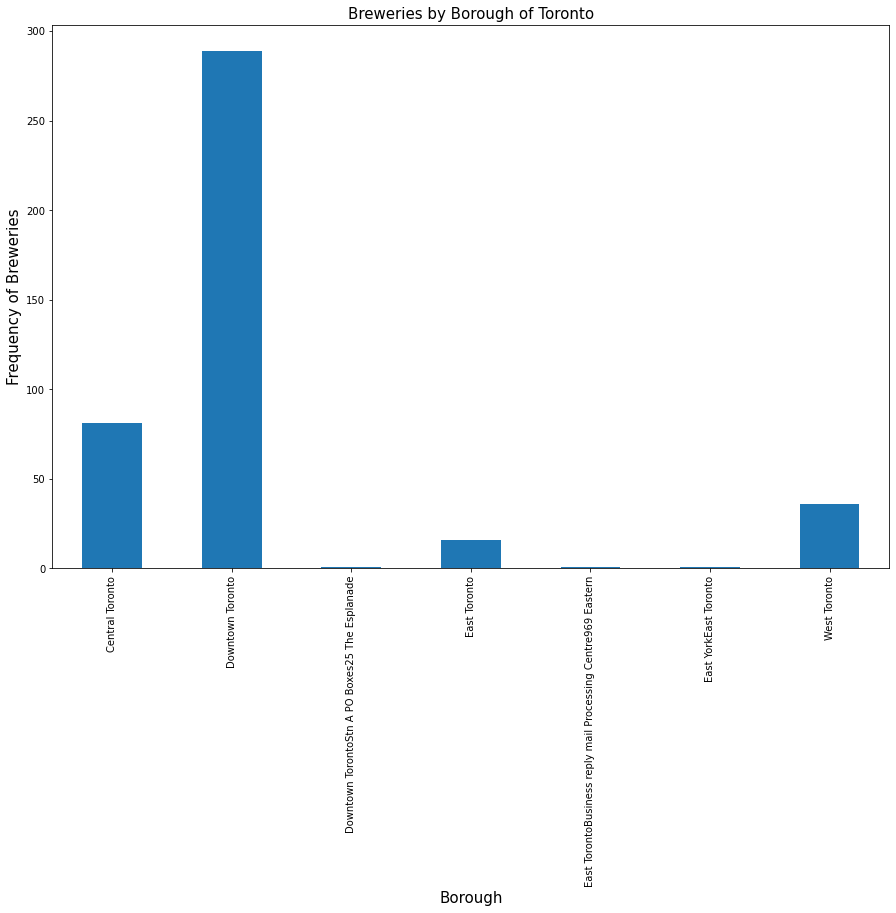

In [31]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,10))
plt.title('Breweries by Borough of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Breweries", fontsize=15)
toronto_Brewery_merged.groupby('Borough')['Brewery'].count().plot(kind='bar')
plt.show()

### run k-means to cluster Toronto into 5 clusters

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:17: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.


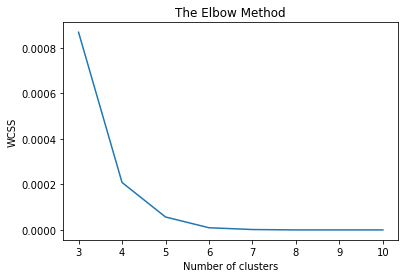

In [32]:

# Using the elbow method to find the optimal number of clusters
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_Brewery_Clustering = toronto_Brewery.drop('Borough', 1)


wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_Brewery_Clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

#### Elbow Method shows 5 as the best K value.

In [33]:
# set number of clusters
kclusters = 5

toronto_Brewery_Clustering = toronto_Brewery.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_Brewery_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 3, 1, 4, 0, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3,
       0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 1, 3, 3, 0, 3, 0, 2], dtype=int32)

In [34]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_Brewery_Clustering_merged = toronto_Brewery.copy()
# add clustering labels
toronto_Brewery_Clustering_merged["Cluster Labels"] = kmeans.labels_
toronto_Brewery_Clustering_merged.head()

,Borough,Brewery,Cluster Labels
0,East Toronto,0.000000,0
1,East YorkEast Toronto,0.000000,0
2,East Toronto,0.010000,3
3,East Toronto,0.025641,1
4,East Toronto,0.040000,4


In [35]:
# Merge geodata and Brewery daa per borough cluster labels
toronto_Brewery_Clustering_merged2 = pd.merge(toronto_df, toronto_Brewery_Clustering_merged[['Borough','Brewery','Cluster Labels']], on='Borough')

toronto_Brewery_Clustering_merged2.head()

,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,0.00,0
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,0.00,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,0.00,0
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,0.02,1
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,0.00,0


In [36]:
# Let's sort the results by Cluster Labels
print(toronto_Brewery_Clustering_merged2.shape)
toronto_Brewery_Clustering_merged2.sort_values(["Cluster Labels"], inplace=True)
toronto_Brewery_Clustering_merged2

(425, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.000000,0
253,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
252,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
249,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
246,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
245,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
244,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
243,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
242,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0
240,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.000000,0


#### Use Folium to display clusters by Borough

In [37]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_Brewery_Clustering_merged2['Latitude'], toronto_Brewery_Clustering_merged2['Longitude'], toronto_Brewery_Clustering_merged2['Borough'], toronto_Brewery_Clustering_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Review Clusters

In [38]:
# Cluster 0
toronto_Brewery_Cluster0 = toronto_Brewery_Clustering_merged2.loc[toronto_Brewery_Clustering_merged2['Cluster Labels'] == 0]
print(toronto_Brewery_Cluster0.shape)
toronto_Brewery_Cluster0

(285, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,0
253,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
252,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
249,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
246,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
245,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
244,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
243,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
242,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0
240,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.0,0


In [39]:
# Cluster 1
toronto_Brewery_Cluster1 = toronto_Brewery_Clustering_merged2.loc[toronto_Brewery_Clustering_merged2['Cluster Labels'] == 1]
print(toronto_Brewery_Cluster1.shape)
toronto_Brewery_Cluster1

(44, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
230,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0.030000,1
196,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0.030000,1
145,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0.030000,1
247,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.030000,1
311,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0.028169,1
94,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0.030000,1
179,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,0.030000,1
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.020000,1
156,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0.020000,1
213,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0.030000,1


In [40]:
# Cluster 2
toronto_Brewery_Cluster2 = toronto_Brewery_Clustering_merged2.loc[toronto_Brewery_Clustering_merged2['Cluster Labels'] == 2]
print(toronto_Brewery_Cluster2.shape)
toronto_Brewery_Cluster2

(1, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
424,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558,0.061224,2


In [41]:
# Cluster 3
toronto_Brewery_Cluster3 = toronto_Brewery_Clustering_merged2.loc[toronto_Brewery_Clustering_merged2['Cluster Labels'] == 3]
print(toronto_Brewery_Cluster3.shape)
toronto_Brewery_Cluster3

(91, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
46,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.01,3
408,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.01,3
13,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.01,3
390,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.01,3
27,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.01,3
388,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0.01,3
406,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.01,3
29,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.01,3
30,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.01,3
381,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0.01,3


In [42]:
# Cluster 4
toronto_Brewery_Cluster4 = toronto_Brewery_Clustering_merged2.loc[toronto_Brewery_Clustering_merged2['Cluster Labels'] == 4]
print(toronto_Brewery_Cluster4.shape)
toronto_Brewery_Cluster4

(4, 7)


,PostalCode,Borough,Neighborhoods,Latitude,Longitude,Brewery,Cluster Labels
304,M4M,East Toronto,Studio District,43.659526,-79.340923,0.04,4
292,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.04,4
300,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0.04,4
296,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0.04,4


### Results

Cluster 0: This clusters consists primarily of Downtown, Central and West Boroughs, has no breweries.

Cluster 1: Mostly Downtown, though in different Neighborhoods, shows some of the highest frequency of Breweries.

Cluster 2: This cluster seems to be the least suitable due to the surrounding vicinity.

Cluster 3: This cluster, Downtown, Central, West and some East Boroughs has Breweries, though some of the lowest frequency.

Cluster 4: This cluster in East Toronto Shows the highest frequency, and would most likely be the most competitive.

### Discussion

Based on the above results, Clusters 2 and 4 should be eliminated as options due to the vicinity and high frequency respectively.

Cluster 1 also shows high frequency of breweries which still may cause increase competition, which is not suitable for the stakeholders.

Based on the analysis, Cluster 0 should be the primary cluster for a new Brewery. Cluster 3 would be the secondary Cluster which may also yield strong opportunity as there are some breweries which may prove to have an already established client base.

### Conclusion

This Project was to identify for the stakeholders a new location for opening a Brewery, while mitigating too close of proximity to other Breweries. Overall, Downtown Toronto shows some of the highest frequency of Breweries. However, by using k Means Clustering, it has been identified that in Clusters 0 and 3 there are opportunities for the stakeholders to review in the Downtown Areas which either have no Breweries or very little. These locations would likely yield the best opportunity for success due to the concentration of activity in the Downtown Toronto area.